# EDA of the dataset ha5d


Import dataset

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc



In [2]:
adata = ad.read_h5ad('/Users/pacohoche/Desktop/AI-1 Project/AI-1-Project-Single-Cell-/Data/single_cell.h5ad')

In [3]:
scInfo = pd.read_csv('/Users/pacohoche/Desktop/AI-1 Project/AI-1-Project-Single-Cell-/Data/singlecell_train.csv')

In [4]:
scInfo

,ID,cell_type,clusters
0,f8f4122d32,LMPP_broad,2
1,0710f78e38,LTHSC_broad,3
2,449e822f38,MEP_broad,4
3,c8b77d8ad4,STHSC_broad,8
4,a44b6f05bc,GMP_broad,1
...,...,...,...
1069,bff1bc24af,other,9
1070,c03ad51677,CMP_broad,0
1071,ac69ab7bae,MEP_broad,4
1072,87cb8c1a31,MPP3_broad,7


In [5]:
adata.X.shape

(1499, 4290)

In [6]:
adata.obs

,ID
0,f8f4122d32
1,c547632b57
2,c2e46e7dfc
3,0710f78e38
4,449e822f38
...,...
1494,f255ea261b
1495,ac69ab7bae
1496,12350b2804
1497,87cb8c1a31


In [7]:
adata.var

,ENSG,Symbol
0,ENSMUSG00000030159,Clec1b
1,ENSMUSG00000053470,Kdm3a
2,ENSMUSG00000041729,Coro2b
3,ENSMUSG00000048489,Depp1
4,ENSMUSG00000046080,Clec9a
...,...,...
4285,ENSMUSG00000024423,Impact
4286,ENSMUSG00000054321,Taf4b
4287,ENSMUSG00000024420,Zfp521
4288,ENSMUSG00000037346,Hrh4


### We need to map the labels into the gene expression, this is so we have a better view of what we need to do 

In [9]:
# add the cell type information to the AnnData object
# Merge based on the column "ID"
scInfo['clusters'] = scInfo['clusters'].astype('category')

adata.obs = (adata.obs.merge(scInfo[['ID', 'cell_type', 'clusters']], on='ID', how='left'))

In [10]:
adata.obs.head()

,ID,cell_type,clusters
0,f8f4122d32,LMPP_broad,2
1,c547632b57,NaN,NaN
2,c2e46e7dfc,NaN,NaN
3,0710f78e38,LTHSC_broad,3
4,449e822f38,MEP_broad,4


In [11]:
# count the numbers of NaN in the cell_type column
adata.obs['cell_type'].isna().sum()

np.int64(425)

So we see that we have 425 cells in the single_cell dataset that has no clusters. 

Need to understand if these missing ones are the one we want to predict, or if they are the ones that are missing and we just need to discard them. 

### Clusters are indeed the cell type, so we are trying to infer the cell type(cluster so it's numerical)

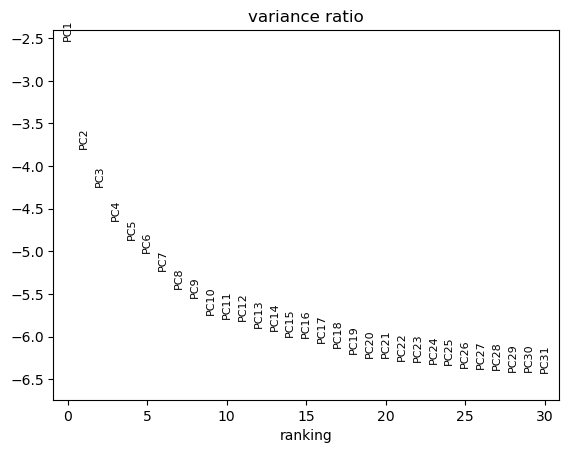

/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


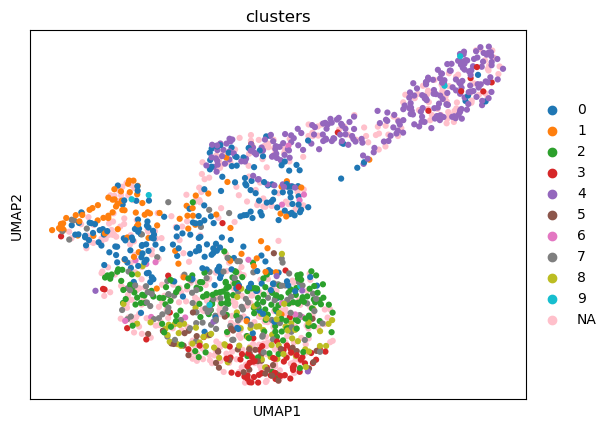

In [12]:
import scanpy as sc

sc.pp.scale(adata, max_value=10) # center the data 
sc.tl.pca(adata, svd_solver='arpack') # compute PCA
sc.pl.pca_variance_ratio(adata, log=True) # plot the variance ratio


sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # compute the neighborhood graph
sc.tl.umap(adata) # compute UMAP
sc.pl.umap(adata, color=['clusters'], na_color='pink') # plot UMAP
# Want to see on the figure the cells that do not have a cell type assigned



# In order to avoid problems (ADD JUSTIFICATION)
### We can keep the HVG only, let's start with 2000, a number that is accorded to be quit simple to start with. 

In [13]:
adata

AnnData object with n_obs × n_vars = 1499 × 4290
    obs: 'ID', 'cell_type', 'clusters'
    var: 'ENSG', 'Symbol', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [14]:
adata_hvg = adata.copy()

sc.pp.highly_variable_genes(adata_hvg, n_top_genes=2000, subset=True)  # now ~2000 genes


/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
adata_hvg

AnnData object with n_obs × n_vars = 1499 × 2000
    obs: 'ID', 'cell_type', 'clusters'
    var: 'ENSG', 'Symbol', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap', 'clusters_colors', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

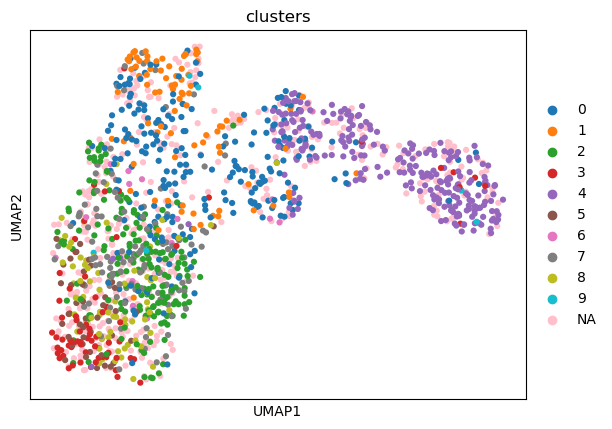

In [17]:
#do the UMAP again with the highly variable genes only
sc.pp.scale(adata_hvg, max_value=10) # center the data
sc.tl.pca(adata_hvg, svd_solver='arpack') # compute PCA
# sc.pl.pca_variance_ratio(adata_hvg, log=True) # plot the variance
sc.pp.neighbors(adata_hvg, n_neighbors=10, n_pcs=40) # compute the neighborhood graph
sc.tl.umap(adata_hvg) # compute UMAP
sc.pl.umap(adata_hvg, color=['clusters'], na_color='pink') #


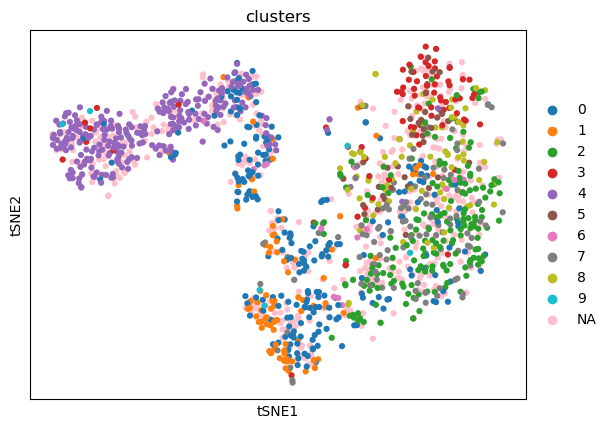

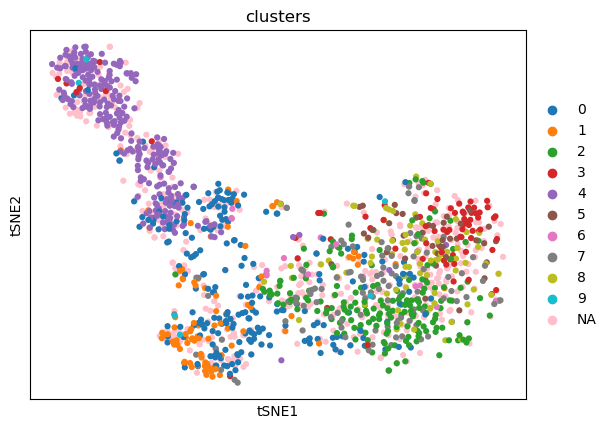

In [18]:
# also want to perform t-SNE on the data
sc.tl.tsne(adata, n_pcs=40)
sc.pl.tsne(adata, color=['clusters'], na_color='pink') #
sc.tl.tsne(adata_hvg, n_pcs=40)
sc.pl.tsne(adata_hvg, color=['clusters'], na_color='pink') #


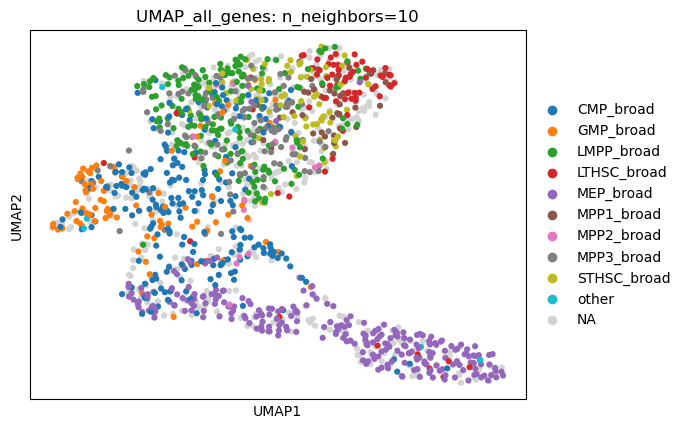

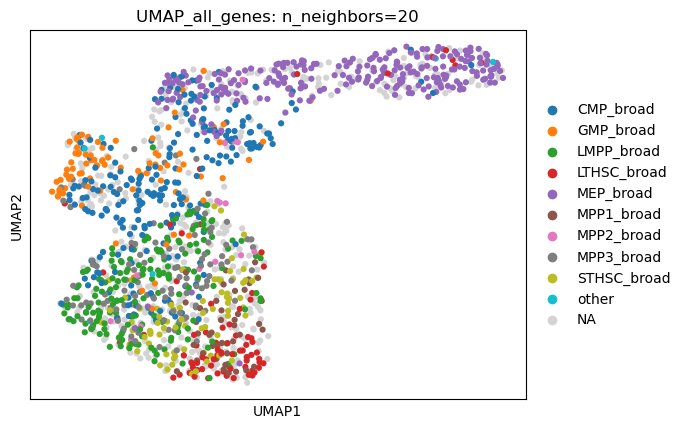

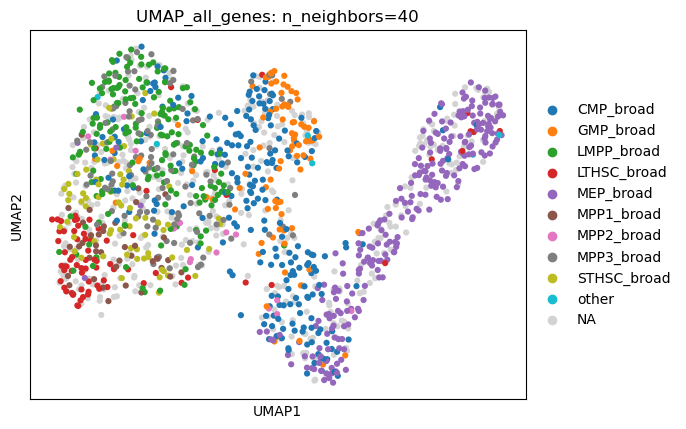

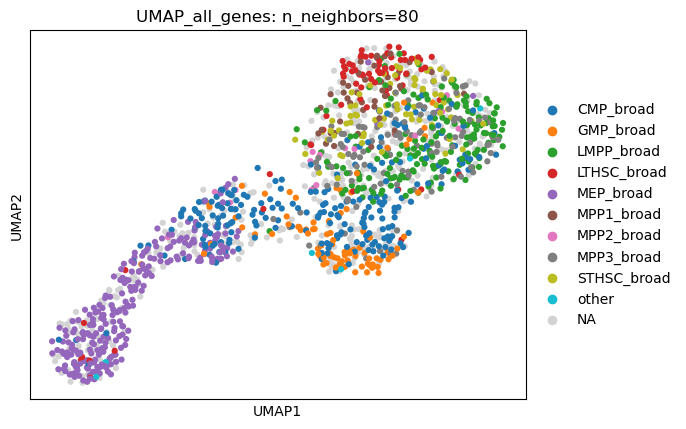

In [22]:
for k in [10, 20, 40, 80]:
    sc.pp.neighbors(adata, n_neighbors=k, n_pcs=30)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color="cell_type", title=f"UMAP_all_genes: n_neighbors={k}")


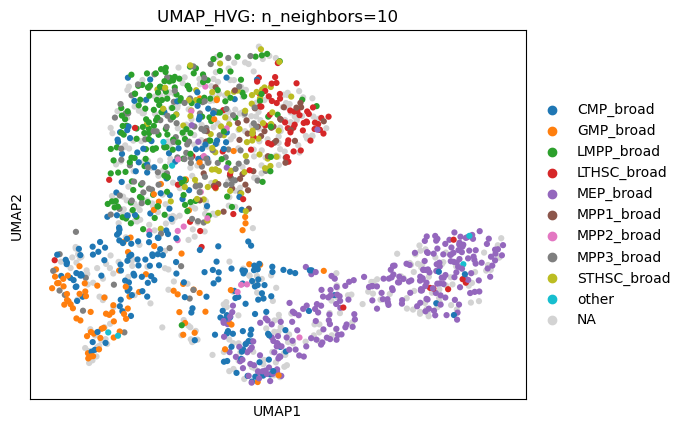

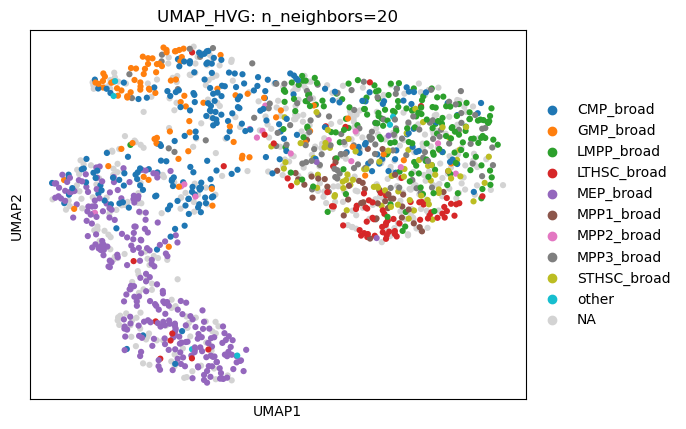

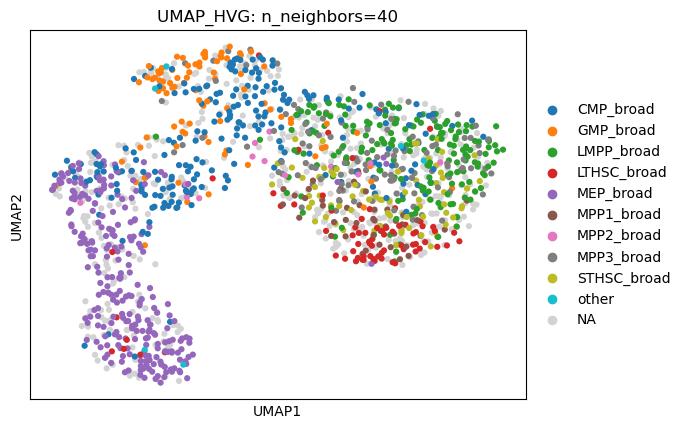

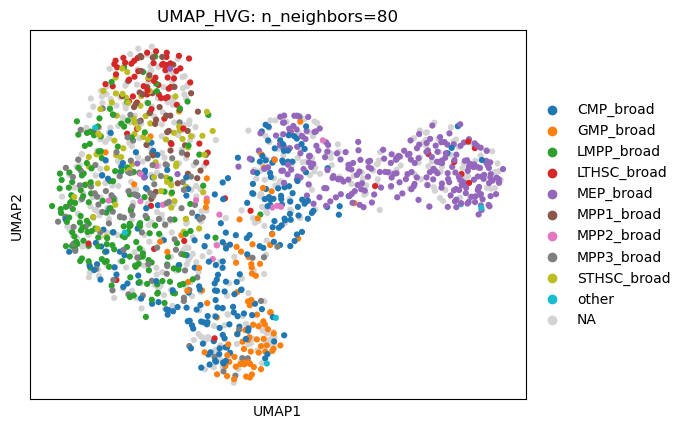

In [21]:
for k in [10, 20, 40, 80]:
    sc.pp.neighbors(adata_hvg, n_neighbors=k, n_pcs=30)
    sc.tl.umap(adata_hvg)
    sc.pl.umap(adata_hvg, color="cell_type", title=f"UMAP_HVG: n_neighbors={k}")

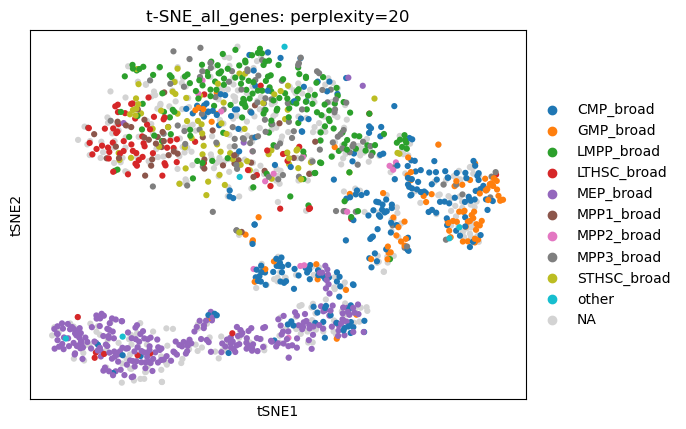

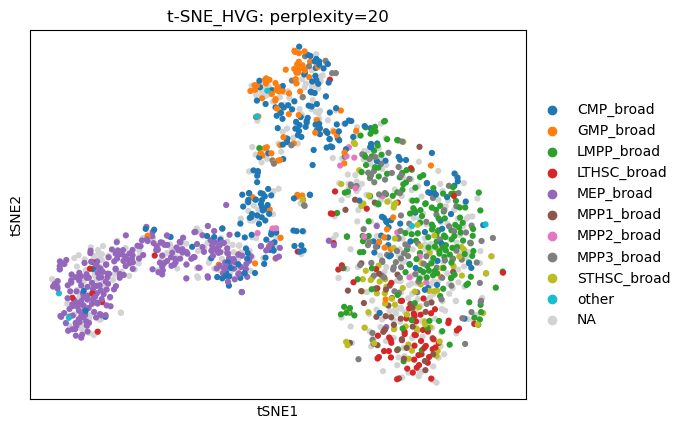

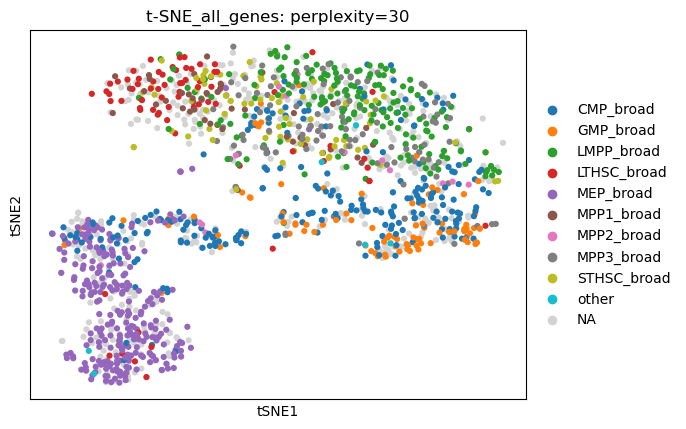

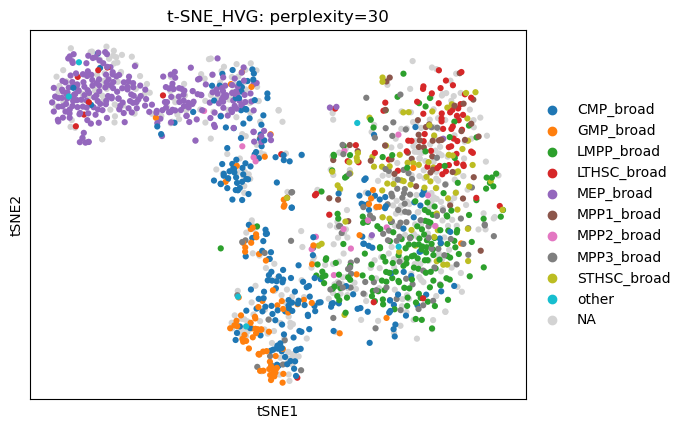

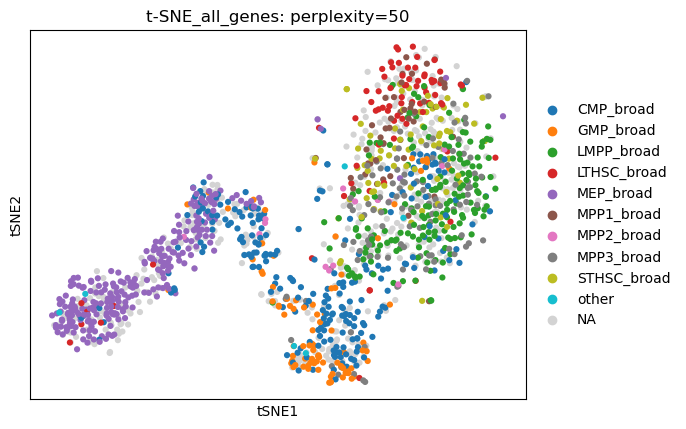

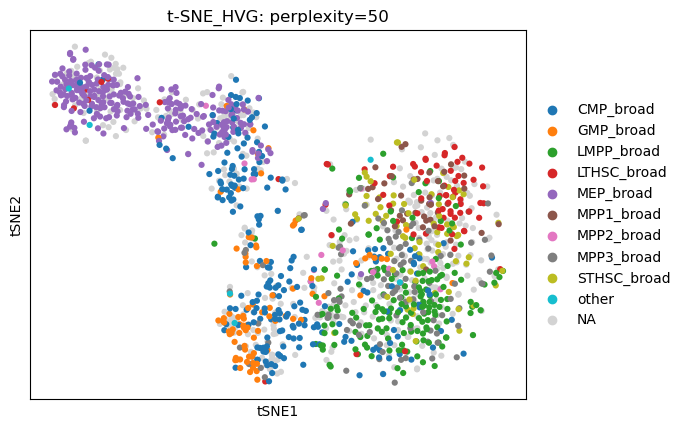

In [23]:
for p in [20, 30, 50]:
    # all genes
    sc.tl.tsne(
        adata,
        n_pcs=50,
        perplexity=p,
    )
    sc.pl.tsne(adata, color="cell_type", title=f"t-SNE_all_genes: perplexity={p}")

    # HVG
    sc.tl.tsne(
        adata_hvg,
        n_pcs=50,
        perplexity=p,
    )
    sc.pl.tsne(adata_hvg, color="cell_type", title=f"t-SNE_HVG: perplexity={p}")

## Comments on the UMAP. 

In [24]:
# we want to save the datasets, both the full and the HVG one
# into csv files for further analysis
adata.to_csv('/Users/pacohoche/Desktop/AI-1 Project/AI-1-Project-Single-Cell-/Data_CSV/adata_full.csv')
adata_hvg.to_csv('/Users/pacohoche/Desktop/AI-1 Project/AI-1-Project-Single-Cell-/Data_CSV/adata_hvg.csv')

AttributeError: 'AnnData' object has no attribute 'to_csv'

In [34]:
X = adata.X
row_index = adata.obs["ID"].astype(str).values   # shape (1499,)
col_names = adata.var["Symbol"].astype(str).values # shape (4290,)
df_all = pd.DataFrame(X, index=row_index, columns=col_names)
df_all
# we also want the cells cluster and cell_type assigned
df_all["cluster"] = adata.obs["clusters"].values
df_all["cell_type"] = adata.obs["cell_type"].values


In [35]:
df_all.head()

,Clec1b,Kdm3a,Coro2b,Depp1,Clec9a,Phf6,Tmem167b,Kbtbd7,Rag2,Hmgcs1,...,Cables1,B4galt6,Rnf125,Impact,Taf4b,Zfp521,Hrh4,Psma8,cluster,cell_type
f8f4122d32,-0.253997,-0.909181,-0.459152,-0.266166,-0.125159,-1.416939,2.137775,-0.574714,3.327965,1.858908,...,-0.502104,-0.159891,-0.390847,-0.926282,-1.002289,0.181816,-0.064918,2.288715,2,LMPP_broad
c547632b57,-0.253997,-0.539075,-0.459152,-0.266166,-0.125159,1.349055,2.564433,-0.100039,-0.010832,-0.623287,...,-0.502104,0.023667,-0.250415,1.117386,-0.528065,0.186905,-0.064918,-0.054558,NaN,NaN
c2e46e7dfc,-0.253997,0.944323,-0.459152,-0.266166,-0.125159,-1.253852,-0.767338,-0.574714,-0.079042,0.077786,...,-0.502104,2.392045,1.809725,0.808135,-0.160130,1.572204,-0.064918,-0.599173,NaN,NaN
0710f78e38,-0.253997,-0.666305,-0.459152,-0.266166,-0.125159,0.503949,-0.507284,2.676757,-0.621492,1.211382,...,1.469079,-0.875999,-0.705866,1.166535,-0.486395,-0.582101,-0.064918,-0.241778,3,LTHSC_broad
449e822f38,-0.253997,-0.275845,1.096180,0.597939,2.129287,-0.977010,-0.767338,-0.041833,-0.621492,0.952548,...,-0.502104,-0.355352,2.247663,1.401348,-0.469913,-0.582101,-0.064918,-0.599173,4,MEP_broad


In [36]:
df_all.to_csv('/Users/pacohoche/Desktop/AI-1 Project/AI-1-Project-Single-Cell-/Data_CSV/full_data_clusters.csv')

### Do the same for HVG 

In [37]:
X = adata_hvg.X
row_index = adata_hvg.obs["ID"].astype(str).values   # shape (1499,)
col_names = adata_hvg.var["Symbol"].astype(str).values # shape (4290,)
df_hvg = pd.DataFrame(X, index=row_index, columns=col_names)
df_hvg
# we also want the cells cluster and cell_type assigned
df_hvg["cluster"] = adata_hvg.obs["clusters"].values
df_hvg["cell_type"] = adata_hvg.obs["cell_type"].values


In [40]:
df_hvg.to_csv('/Users/pacohoche/Desktop/AI-1 Project/AI-1-Project-Single-Cell-/Data_CSV/hvg_data_clusters.csv')

# Some test for feature extraction. 


### Look at markers

/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


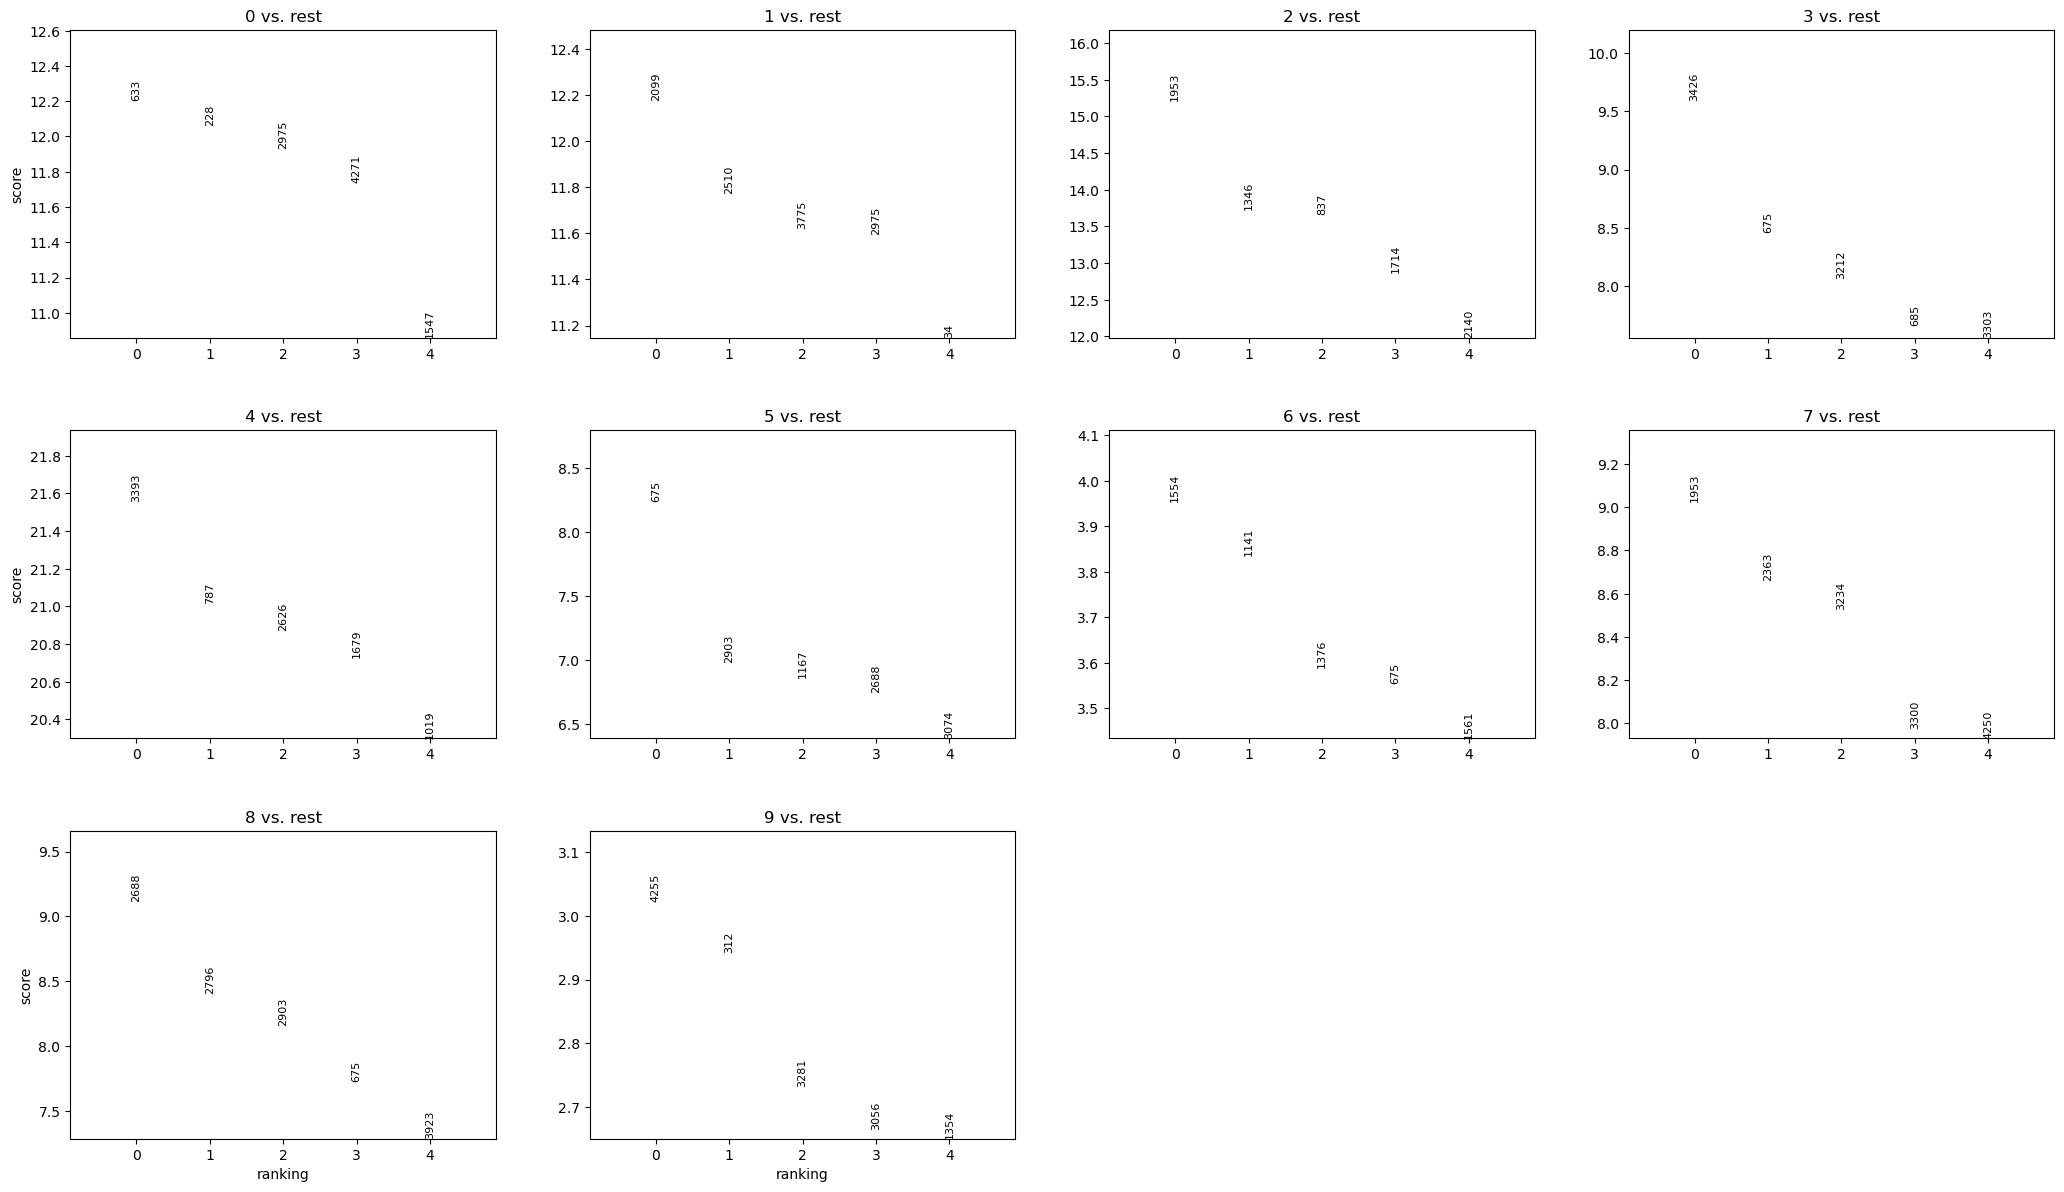

In [45]:
sc.tl.rank_genes_groups(adata, groupby="clusters", method="wilcoxon")

sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)
